<a href="https://colab.research.google.com/github/emanuel379/Introducao-a-Computacao-no-Mercado-Financeiro/blob/main/Trabalho_1_com_a%C3%A7%C3%B5es_de_empresas_internacionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  2 of 2 completed
Asset Ticker, Anualized volatility, Anualized Expected Return
Asset: GC=F, σ: 0.1438056962040501, E[X]: 0.09509029785985557
Asset: NQ=F, σ: 0.22322507779439232, E[X]: 0.2717392863678685
Asset: Least risk portfolio, σ: 0.12360232547725004, E[X]: 0.1456691010274016

Least risk portfolio weights: {'GC=F': 0.93480674782765, 'NQ=F': 0.06519325217234996}



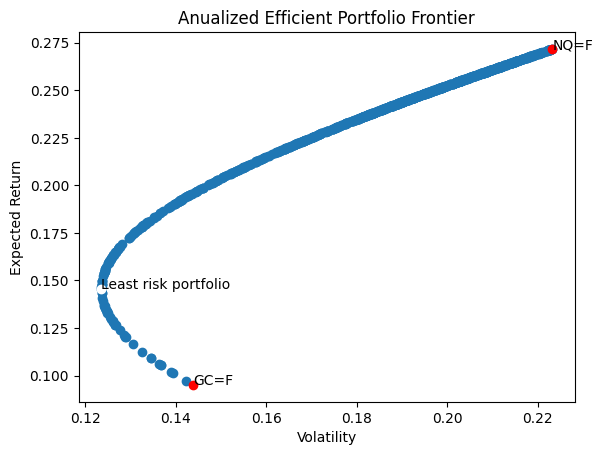

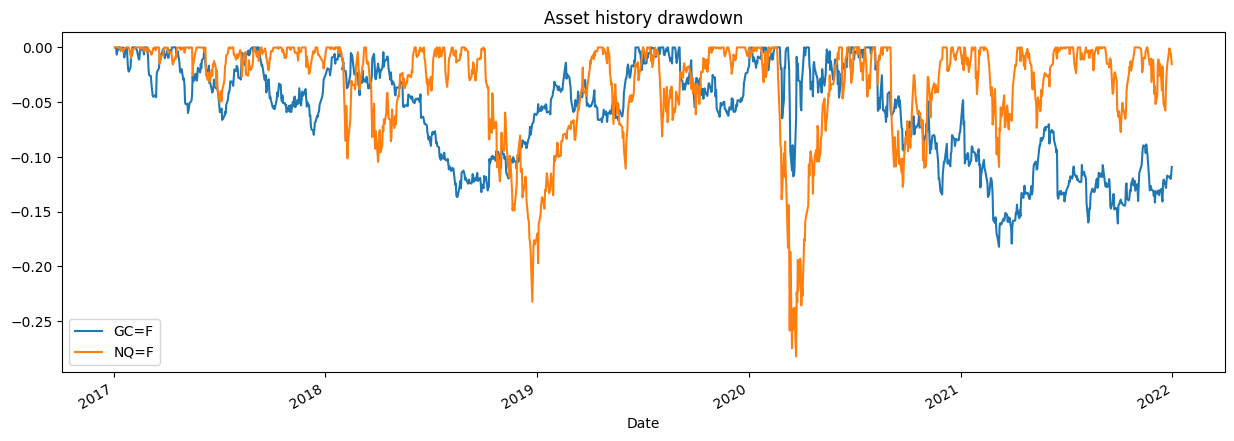

[*********************100%***********************]  3 of 3 completed
Asset Ticker, Anualized volatility, Anualized Expected Return
Asset: AAPL, σ: 0.3044986580487952, E[X]: 0.45391212262611
Asset: AMZN, σ: 0.29433363915932415, E[X]: 0.3463740487096765
Asset: GOOGL, σ: 0.27051948303347345, E[X]: 0.2909444403349979
Asset: Least risk portfolio, σ: 0.2522390805704223, E[X]: 0.3348170584007111

Least risk portfolio weights: {'AAPL': 0.21674372479531928, 'AMZN': 0.2201582064932739, 'GOOGL': 0.5630980687114068}



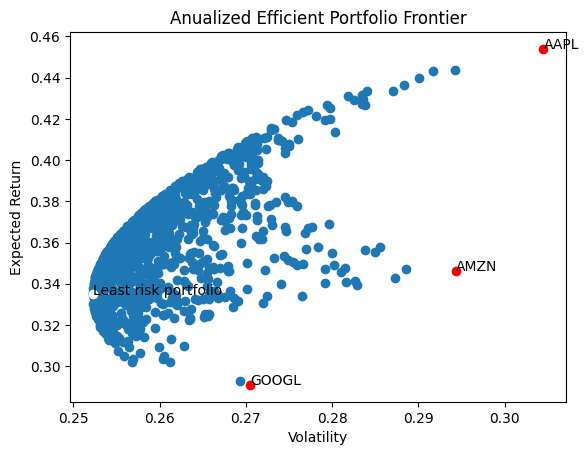

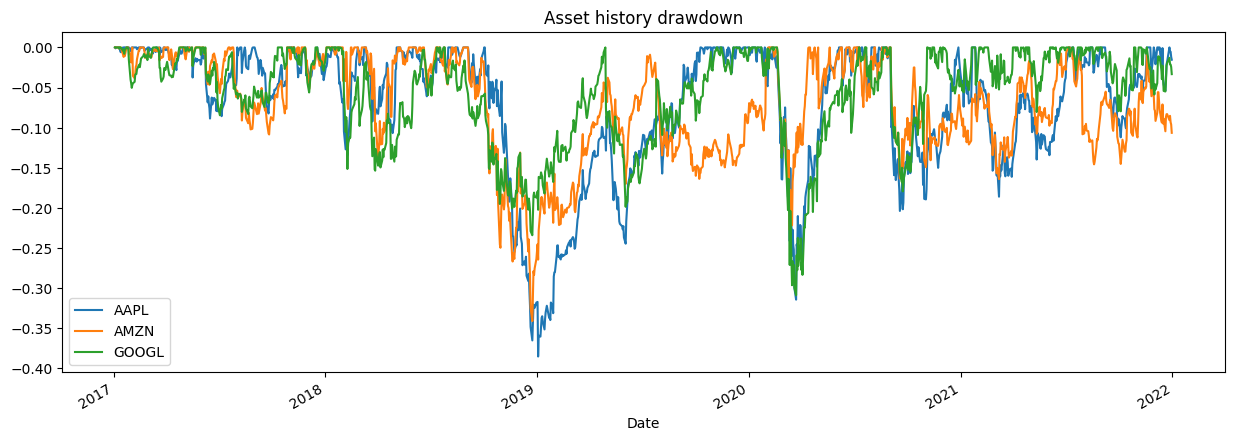

In [ ]:
# Trabalho para a Disciplina SSC0964 - Introdução ao Mercado Financeiro
# Grupo:
# Amanda Caroline de Oliveira Pires - 12559090
# Emanuel Victor da Silva Favorato - 12558151
# Rafael Zimmer - 12542612

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yf

# Use the following framework for displaying graphs when running on a local script environment.
# matplotlib.use('TkAgg')


def load_assets(tickers: list) -> pd.DataFrame:
    """Loads a list of YFinance tickers into a Pandas DataFrame object, as well as caching the downloaded data
    into a DataFrame styled CSV file.

    Args:
        tickers: List of strings representing valid YFinance tickers whose asset information are to be downloaded.

    Returns:
        DataFrame containing column asset-named values, as well as timeframe indexed rows.
    """
    tickers.sort()
    filename = '_'.join(tickers)
    query = ' '.join(tickers)
    try:
        data = pd.read_csv(f"{filename}.csv", header=[0, 1], index_col=[0])

        # If existing cache is of a different set of assets, issue a new download call
        if len(data["Adj Close"].columns) != len(tickers) or (data["Adj Close"].columns != tickers).any():
            raise FileNotFoundError

    except FileNotFoundError:
        print(f"Downloading data for assets: {query}")
        data = yf.download(query, start="2017-01-01", end="2022-01-01")
        data.to_csv(f"{filename}.csv")

    return data


def asset_data(asset):
    """Describe a series of asset values through its mean and standard deviation values."""
    std = asset.pct_change().std() * np.sqrt(252)
    mu = (asset.iloc[-1] / asset.replace(0, 1).iloc[0]) ** (1 / 5) - 1

    return std, mu


def describe_asset(std: float, mu: float, name: str) -> None:
    """Sample console output for attributing description values to a asset."""
    print(f"Asset: {name}, σ: {std}, E[X]: {mu}")


def generate_portfolios(data, n: int = 1000) -> tuple[list, list]:
    """Generate a sample of 'n' random weighted portfolios, specifically the expected return and standard deviation of
    each portfolio, as well as the portfolio with the least risk value and its respective asset weights.

    Args:
        data: DataFrame of assets from which to weight portfolio from.
        n: Total samples to randomly generate for the list of randomized portfolios.

    Returns:
        Expected return and standard deviation of N random weighted portfolios, as well as the least risk portfolio.
    """
    portfolios = []
    assets = data.columns

    least_risk = [np.inf, None, 0]

    for sample in range(n):
        curr_weights = np.random.uniform(0, 1, len(assets))
        curr_weights /= sum(curr_weights)

        std, mu = asset_data(data.dot(curr_weights))

        # Keep track of the portfolio with the least risk value
        if std < least_risk[0]:
            least_risk = [std, mu, curr_weights]

        portfolios.append([std, mu, curr_weights])

    return portfolios, least_risk


def drawdown(assets: list) -> pd.DataFrame:
    """Builds a drawdown series given a list of asset values, which gives the difference value between the
    current through to the last peak.

    Args:
        assets: List of assets to build a drawdown series on top of.

    Returns:
        DataFrame containing columnwise asset drawdown values, with timeframe indexed rows.
    """
    # Convert asset variable to DataFrame to process
    if isinstance(assets, np.ndarray) or isinstance(assets, list):
        assets = pd.DataFrame(assets)

    changes = pd.DataFrame()

    for asset in assets:
        change_asset = np.zeros_like(assets[asset])

        for idx in range(len(assets[asset])):
            change_asset[idx] = (assets[asset].iloc[idx] / assets[asset].iloc[:idx + 1].max() - 1)

        changes[asset] = change_asset

    return changes


def main(tickers):
    data = load_assets(tickers)
    assets = data["Adj Close"]

    print("Asset Ticker, Anualized volatility, Anualized Expected Return")
    single_asset_portfolios = [asset_data(assets[asset]) for asset in assets]
    multiple_asset_portfolios, least_risk = generate_portfolios(assets)

    x, y, z = np.array(multiple_asset_portfolios, dtype=object).T
    plt.scatter(x, y)

    # Plotting the individual assets onto the efficient portfolio graph
    for ticker, asset in zip(tickers, single_asset_portfolios):
        std, mu = asset
        describe_asset(std, mu, ticker)
        plt.scatter(std, mu, color="red")
        plt.text(std, mu, ticker)

    # Plotting the single portfolio that minimizes the total risk and maximizes the return on that level of risk
    std, mu, weights = least_risk
    describe_asset(std, mu, "Least risk portfolio")
    plt.scatter(std, mu, color="white")
    plt.text(std, mu, "Least risk portfolio")
    plt.title("Anualized Efficient Portfolio Frontier")
    plt.xlabel("Volatility")
    plt.ylabel("Expected Return")

    print(f"\nLeast risk portfolio weights: {dict(zip(tickers, weights))}\n")
    plt.show()

    ddown = drawdown(assets[tickers])
    ddown['Date'] = assets.index.values
    ddown.set_index(keys='Date', inplace=True)
    ddown.plot(figsize=(15, 5), title="Asset history drawdown")
    plt.show()


if __name__ == "__main__":
    tickers_binary = ["GC=F", "NQ=F"]
    tickers_triple = ["GOOGL", "AAPL", "AMZN"]

    main(tickers_binary)
    main(tickers_triple)